In [58]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
# Loading the dataset

df = pd.read_csv("real_estate_dubai_original.csv")
df.head()

,transaction_id,trans_group_en,procedure_name_en,instance_date,property_type_en,property_sub_type_en,property_usage_en,reg_type_en,area_name_en,building_name_en,...,nearest_metro_en,nearest_mall_en,rooms_en,has_parking,procedure_area,actual_worth,meter_sale_price,no_of_parties_role_1,no_of_parties_role_2,no_of_parties_role_3
0,3-9-2006-163,Gifts,Grant,16-10-2006,Villa,NaN,Residential,Existing Properties,Mankhool,NaN,...,ADCB Metro Station,Dubai Mall,NaN,0,3162.42,12000000.0,3794.56,3.0,1.0,0.0
1,3-9-2019-2944,Gifts,Grant,13-11-2019,Land,NaN,Residential,Existing Properties,Mankhool,NaN,...,ADCB Metro Station,Dubai Mall,NaN,0,209.09,916659.0,4384.04,2.0,4.0,0.0
2,2-13-2001-690,Mortgages,Mortgage Registration,20-08-2001,Building,NaN,Residential / Commercial,Existing Properties,Oud Metha,NaN,...,Oud Metha Metro Station,Dubai Mall,NaN,0,1337.80,4519342.0,3378.19,1.0,1.0,0.0
3,2-13-2020-9477,Mortgages,Mortgage Registration,30-11-2020,Building,NaN,Residential,Existing Properties,Al Bada,NaN,...,Trade Centre Metro Station,Dubai Mall,NaN,0,278.71,2500000.0,8969.90,1.0,1.0,0.0
4,2-13-1999-532,Mortgages,Mortgage Registration,26-04-1999,Villa,NaN,Residential,Existing Properties,Al Bada,NaN,...,Trade Centre Metro Station,Dubai Mall,NaN,0,3626.93,1900000.0,523.86,1.0,1.0,0.0


In [60]:
# Now we show some basic info about the dataset

print("Shape:", df.shape)
print("\nInfo:")
df.info()

print("\nMissing values per column:")
df.isna().sum()

Shape: (1548772, 24)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1548772 entries, 0 to 1548771
Data columns (total 24 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   transaction_id        1548772 non-null  object 
 1   trans_group_en        1548772 non-null  object 
 2   procedure_name_en     1548772 non-null  object 
 3   instance_date         1548772 non-null  object 
 4   property_type_en      1548772 non-null  object 
 5   property_sub_type_en  1227150 non-null  object 
 6   property_usage_en     1548772 non-null  object 
 7   reg_type_en           1548772 non-null  object 
 8   area_name_en          1548772 non-null  object 
 9   building_name_en      1092627 non-null  object 
 10  project_number        1106097 non-null  float64
 11  project_name_en       1106097 non-null  object 
 12  master_project_en     1319601 non-null  object 
 13  nearest_landmark_en   1265574 non-null  object 
 14  neares

,0
transaction_id,0
trans_group_en,0
procedure_name_en,0
instance_date,0
property_type_en,0
property_sub_type_en,321622
property_usage_en,0
reg_type_en,0
area_name_en,0
building_name_en,456145


In [295]:
# Copying the original data frame to avoid damaging raw data

df_clean = df.copy()

In [296]:
# Now we need to clean 'instance_date' (some rows have Hijri date format)

parsed_dates = pd.to_datetime(df_clean['instance_date'], errors='coerce', dayfirst=True)

invalid_dates = df_clean[parsed_dates.isna()]
print("Invalid dates count:", len(invalid_dates))
print("Examples:\n", invalid_dates['instance_date'].unique()[:10])

df_clean['instance_date'] = parsed_dates
df_clean = df_clean.dropna(subset=['instance_date'])

df_clean.shape

Invalid dates count: 4
Examples:
 ['04-02-1417' '30-01-1420' '02-07-1416' '23-11-1422']


(1548768, 24)

In [297]:
# Now, we need to have information about missing values

missing_count = df_clean.isna().sum()
missing_pct = (missing_count / len(df_clean)) * 100

missing_df = pd.DataFrame({
    "missing_count": missing_count,
    "missing_pct": missing_pct
}).sort_values(by="missing_pct", ascending=False)

missing_df

,missing_count,missing_pct
nearest_mall_en,458118,29.579511
building_name_en,456141,29.451861
nearest_metro_en,449856,29.046055
project_number,442671,28.582138
project_name_en,442671,28.582138
rooms_en,342271,22.099566
property_sub_type_en,321618,20.766054
nearest_landmark_en,283197,18.285308
master_project_en,229167,14.796729
no_of_parties_role_2,968,0.062501


In [298]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1548768 entries, 0 to 1548771
Data columns (total 24 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   transaction_id        1548768 non-null  object        
 1   trans_group_en        1548768 non-null  object        
 2   procedure_name_en     1548768 non-null  object        
 3   instance_date         1548768 non-null  datetime64[ns]
 4   property_type_en      1548768 non-null  object        
 5   property_sub_type_en  1227150 non-null  object        
 6   property_usage_en     1548768 non-null  object        
 7   reg_type_en           1548768 non-null  object        
 8   area_name_en          1548768 non-null  object        
 9   building_name_en      1092627 non-null  object        
 10  project_number        1106097 non-null  float64       
 11  project_name_en       1106097 non-null  object        
 12  master_project_en     1319601 non-null  object 

# Missing Value Strategy

Based on the missing value strategies we have taken in data mining, we can do the following steps:

- Columns with **>25% missing** are *MAR* (Missing At Random).  
  These include: building_name_en, nearest_mall_en, nearest_metro_en, project_name_en, project_number.  
  These do NOT represent errors — many properties simply do not belong to a project or building.  
  → **Strategy: Fill with "Unknown"**

- Columns with **15–25% missing** (rooms_en, property_sub_type_en, nearest_landmark_en)  
  → **Strategy: Median imputation for numeric (rooms_en)**  
  → **"Unknown" for categorical**

- Numeric features essential for modeling (actual_worth, procedure_area) have no missing values.  


In [299]:
# So to fill categorical columns with "Unknown", we need to run the following code:

cat_fill_unknown = [
    'nearest_mall_en',
    'building_name_en',
    'nearest_metro_en',
    'project_name_en',
    'project_number',
    'property_sub_type_en',
    'nearest_landmark_en',
    'master_project_en'
]

for col in cat_fill_unknown:
    df_clean[col] = df_clean[col].fillna("Unknown")

In [300]:
# For numeric `rooms_en` we fill with median, but before that, we should change rooms_en values to numaric values.

def clean_rooms(value):
    if pd.isna(value):
        return np.nan

    v = str(value).strip().lower()

    # Studio → 0 bedrooms
    if v == "studio":
        return 0

    # Single Room → 1 bedroom
    if v == "single room":
        return 1

    # Detect formats like "1 B/R", "2 B/R", "3 BR", "4B/R", etc.
    import re
    match = re.search(r'(\d+)', v)
    if match:
        return int(match.group(1))

    # Commercial / facility units → treat as missing
    commercial_keywords = ["office", "shop", "store", "gym"]
    if any(k in v for k in commercial_keywords):
        return np.nan

    # PENTHOUSE → inconsistent bedroom counts → treat as missing
    if "penthouse" in v:
        return np.nan

    # If format unknown → treat as missing
    return np.nan

df_clean['rooms_en'] = df_clean['rooms_en'].apply(clean_rooms)
df_clean['rooms_en'] = df_clean['rooms_en'].fillna(df_clean['rooms_en'].median())



In [301]:
# Lastly, for very small missingness we fill with 0

for col in ['no_of_parties_role_1', 'no_of_parties_role_2', 'no_of_parties_role_3']:
    df_clean[col] = df_clean[col].fillna(0)

In [302]:
# For the target we can choose either actual_worth or meter_sale_price.
# By choosing any of them, the other should be removed to avoid data leakage.
# Since we choose actual_worth to be the target, we need to remove meter_sale_price

df_clean = df_clean.drop(columns=['meter_sale_price'])

In [303]:
# Remove unrealistic procedure_area and price_per_sqm outliers

df_model = df_model[df_model['procedure_area'] >= 5]
df_model = df_model[df_model['procedure_area'] < 50000]
df_model = df_model[df_model['price_per_sqm'] < 200000]
df_model = df_model[df_model['price_per_sqm'] > 200]

In [304]:
# Now, we need to remove the duplicates and invalid records:

before = len(df_clean)
df_clean = df_clean.drop_duplicates()
after = len(df_clean)
print("Removed duplicates:", before - after)

df_clean = df_clean[df_clean['procedure_area'] > 0]
df_clean = df_clean[df_clean['actual_worth'] > 0]

df_clean.shape

Removed duplicates: 0


(1548768, 23)

In [305]:
# After we checked the columns below, we have a high cardinality and we
# cannot do one hot coding for them, then we checked that we can drop the
# columns because they do not contribute predictive power anyway.

drop_cols = [
    # 'transaction_id',
    'building_name_en',
    'project_number',
    'project_name_en'
]

df_model = df_clean.drop(columns=drop_cols)

In [306]:
# Now, we need to do encoding using Medium-Cardinality
# for the columns below because they have high cardinality
# and we still can't do one hot encoding.

freq_cols = [
    'area_name_en',
    'master_project_en',
    'nearest_metro_en',
    'procedure_name_en'
]

for col in freq_cols:
    freq = df_model[col].value_counts()
    df_model[col] = df_model[col].map(freq)


In [307]:
# For the categorical columns below, we can do one hot encoding:

one_hot_cols = [
    'property_sub_type_en',
    'nearest_landmark_en',
    'property_usage_en',
    'nearest_mall_en',
    'property_type_en',
    'trans_group_en',
    'reg_type_en'
]

In [308]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1548768 entries, 0 to 1548771
Data columns (total 23 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   transaction_id        1548768 non-null  object        
 1   trans_group_en        1548768 non-null  object        
 2   procedure_name_en     1548768 non-null  object        
 3   instance_date         1548768 non-null  datetime64[ns]
 4   property_type_en      1548768 non-null  object        
 5   property_sub_type_en  1548768 non-null  object        
 6   property_usage_en     1548768 non-null  object        
 7   reg_type_en           1548768 non-null  object        
 8   area_name_en          1548768 non-null  object        
 9   building_name_en      1548768 non-null  object        
 10  project_number        1548768 non-null  object        
 11  project_name_en       1548768 non-null  object        
 12  master_project_en     1548768 non-null  object 

In [309]:
# Now, we do feature engineering

df_model['price_per_sqm'] = df_model['actual_worth'] / df_model['procedure_area']
df_model['year'] = df_model['instance_date'].dt.year
df_model['month'] = df_model['instance_date'].dt.month
df_model['is_recent'] = (df_model['year'] >= 2015).astype(int)

df_model[['actual_worth', 'procedure_area', 'price_per_sqm', 'year', 'month', 'is_recent']].head()

,actual_worth,procedure_area,price_per_sqm,year,month,is_recent
0,12000000.0,3162.42,3794.562392,2006,10,0
1,916659.0,209.09,4384.040365,2019,11,1
2,4519342.0,1337.80,3378.189565,2001,8,0
3,2500000.0,278.71,8969.897026,2020,11,1
4,1900000.0,3626.93,523.859021,1999,4,0


In [310]:
# Now, we need to define the target for Classification
# We will create a price category (Low / Medium / High) based on actual_worth column

# Use quantiles to split price into 3 classes
q1 = df_model['actual_worth'].quantile(0.33)
q2 = df_model['actual_worth'].quantile(0.66)

def price_cat(x):
    if x <= q1:
        return "Low"
    elif x <= q2:
        return "Medium"
    return "High"

df_model['price_category'] = df_model['actual_worth'].apply(price_cat)

In [ ]:
# Since we cleaned the data, we need to export it to an CSV file, then we convert it to MySQL.

df_clean.to_csv("dubai_real_estate_clean.csv", index=False)

In [311]:
# Now, we prepare features for classification

target = "price_category"

numeric_features = [
    'rooms_en',
    'has_parking',
    'procedure_area',
    'no_of_parties_role_1',
    'no_of_parties_role_2',
    'no_of_parties_role_3',
    'year',
    'month',
    'is_recent'
]

# Since we still have over 1M records, we see running the RandomForestClassifier
# algorism takes too much time and we should do sampling to take a portion of data.

# Remove extremely high price per sqm values
df_filtered = df_model;
df_filtered['price_per_sqm'] = df_filtered['actual_worth'] / df_filtered['procedure_area']
p99_price = df_filtered['price_per_sqm'].quantile(0.99)
df_filtered = df_filtered[df_filtered['price_per_sqm'] <= p99_price]

df_sample = df_filtered.sample(n=200_000, random_state=42)

X = df_sample[one_hot_cols + numeric_features + freq_cols]
y = df_sample[target]

In [312]:
# Spliting the dataset to testing and training data

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

In [313]:
# We do one hot encoding for some columns

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), one_hot_cols)
    ],
    remainder='passthrough'
)

In [314]:
# Then we do classification

clf = RandomForestClassifier(
    n_estimators=50,     # reduce trees
    max_depth=15,        # limit depth
    random_state=42,
    n_jobs=-1
)

clf_pipeline = Pipeline(steps=[
    ('prep', preprocessor),
    ('model', clf)
])

clf_pipeline.fit(X_train, y_train)
y_pred = clf_pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReport:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8334

Report:
               precision    recall  f1-score   support

        High       0.86      0.88      0.87     20207
         Low       0.89      0.84      0.86     19870
      Medium       0.76      0.78      0.77     19923

    accuracy                           0.83     60000
   macro avg       0.83      0.83      0.83     60000
weighted avg       0.83      0.83      0.83     60000


Confusion Matrix:
 [[17766   178  2263]
 [  431 16699  2740]
 [ 2403  1981 15539]]


In [323]:
# To know which feature is has most importance

importances = clf_pipeline.named_steps['model'].feature_importances_
feature_names = clf_pipeline.named_steps['prep'].get_feature_names_out()

fi = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

fi.head(20)

,feature,importance
60,remainder__procedure_area,0.229859
58,remainder__rooms_en,0.129952
64,remainder__year,0.068876
67,remainder__area_name_en,0.058080
68,remainder__master_project_en,0.055974
69,remainder__nearest_metro_en,0.042562
13,onehot__property_sub_type_en_Unknown,0.029674
51,onehot__property_type_en_Unit,0.025929
70,remainder__procedure_name_en,0.025022
2,onehot__property_sub_type_en_Flat,0.023559


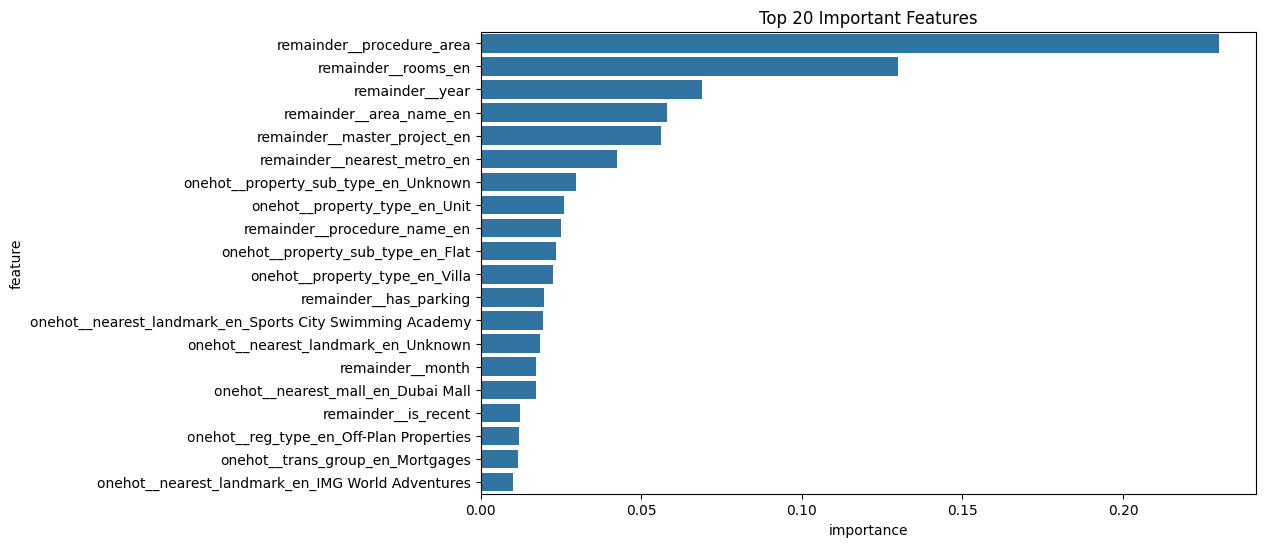

In [324]:
# Visualizating the most 20 important features

plt.figure(figsize=(10,6))
sns.barplot(data=fi.head(20), x='importance', y='feature')
plt.title("Top 20 Important Features")
plt.show()

In [325]:
# Preparing dataset for clustering

df_filtered = df_model;

freq_features = ['property_type_en', 'property_usage_en', 'area_name_en']

for col in freq_features:
    freq_map = df_filtered[col].value_counts(normalize=True).to_dict()
    df_filtered[col + '_freq'] = df_filtered[col].map(freq_map)

df_filtered['price_per_sqm'] = df_filtered['actual_worth'] / df_filtered['procedure_area']
p99_price = df_filtered['price_per_sqm'].quantile(0.99)
df_filtered = df_filtered[df_filtered['price_per_sqm'] <= p99_price]

df_filtered = df_filtered[
    (df_model['procedure_area'] >= 20) &
    (df_model['procedure_area'] <= 5000) &
    (df_model['price_per_sqm'] >= 200) &
    (df_model['price_per_sqm'] <= 50000)
]

df_cluster_sample = df_filtered.sample(n=30000, random_state=42)

df_cluster_sample['procedure_area_log'] = np.log1p(df_cluster_sample['procedure_area'])

cluster_features = [
    'price_per_sqm',
    'procedure_area_log',
    'rooms_en',
    'year',
    'has_parking',
    'property_type_en_freq',
    'property_usage_en_freq',
    'area_name_en_freq'
]

X_cluster = df_cluster_sample[cluster_features]

scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_cluster_scaled)
    print(k, silhouette_score(X_cluster_scaled, labels))

/tmp/ipython-input-2006526394.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered = df_filtered[


2 0.3663089845014346
3 0.23713068540769355
4 0.2555472015235328
5 0.24341427998771578
6 0.2858264877711868


In [327]:
# Run KMeans after we choose 2 clusters based on the output we have (0.3663089845014346)

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df_cluster_sample['cluster'] = kmeans.fit_predict(X_cluster_scaled)

In [328]:
# Showing the clusters

centers_scaled = kmeans.cluster_centers_
centers = scaler.inverse_transform(centers_scaled)

cluster_centers_df = pd.DataFrame(
    centers,
    columns=cluster_features
)
cluster_centers_df

,price_per_sqm,procedure_area_log,rooms_en,year,has_parking,property_type_en_freq,property_usage_en_freq,area_name_en_freq
0,8575.988641,6.116308,1.691380,2017.409143,0.000455,0.147681,0.665846,0.016025
1,14551.871833,4.460189,1.256673,2018.935301,0.930020,0.705365,0.758249,0.039061


In [336]:
# The summary of the clusters

summary = df_cluster_sample.groupby('cluster')[cluster_features].mean()
summary

,price_per_sqm,procedure_area_log,rooms_en,year,has_parking,property_type_en_freq,property_usage_en_freq,area_name_en_freq
cluster,,,,,,,,
0,8575.988641,6.116308,1.691380,2017.409143,0.000455,0.147681,0.665846,0.016025
1,14551.871833,4.460189,1.256673,2018.935301,0.930020,0.705365,0.758249,0.039061


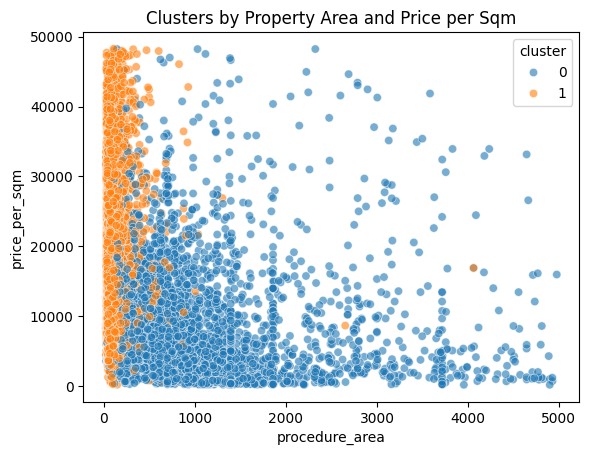

In [337]:
# Visualizaing the clusters on the scatterplot (Area vs Price per SQM)

sns.scatterplot(
    x=df_cluster_sample['procedure_area'],
    y=df_cluster_sample['price_per_sqm'],
    hue=df_cluster_sample['cluster'],
    palette='tab10',
    alpha=0.6
)
plt.title("Clusters by Property Area and Price per Sqm")
plt.show()

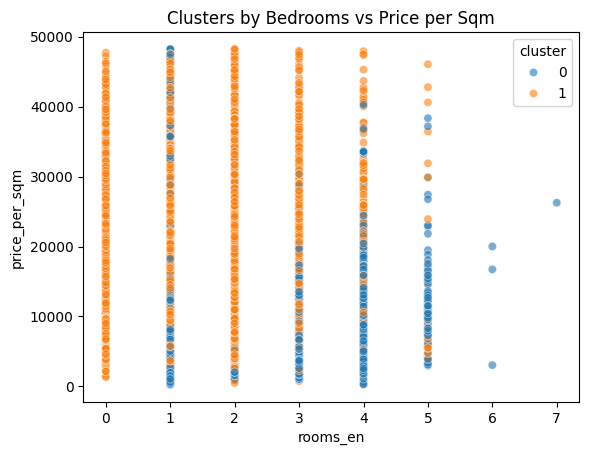

In [331]:
# Visualizaing the clusters on the scatterplot (Bedrooms vs Price per SQM)

sns.scatterplot(
    x=df_cluster_sample['rooms_en'],
    y=df_cluster_sample['price_per_sqm'],
    hue=df_cluster_sample['cluster'],
    palette='tab10',
    alpha=0.6
)
plt.title("Clusters by Bedrooms vs Price per Sqm")
plt.show()